In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phaadasyn/final_data.csv
/kaggle/input/phaadasyn/pha_map.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/kaggle/input/phaadasyn/final_data.csv")

In [4]:
y = pd.read_csv("/kaggle/input/phaadasyn/pha_map.csv")

In [5]:
X = df.drop(columns=['albedo', 'rot_per', 'e', 'a', 'q', 'om', 'w', 'ma', 'ad'])

In [6]:
X.isnull().sum()

H           0
diameter    0
i           0
n           0
per         0
moid_ld     0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.metrics import sensitivity_specificity_support, classification_report_imbalanced
from imblearn.over_sampling import ADASYN

In [8]:
ad = ADASYN(random_state=42)
X_resampled, y_resampled = ad.fit_resample(X, y)

In [9]:
X_resampled.shape

(2618891, 6)

In [10]:
y_resampled.value_counts()

pha
0      1309593
1      1309298
Name: count, dtype: int64

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=43)

In [12]:
y_train.value_counts()

pha
1      1047936
0      1047176
Name: count, dtype: int64

In [13]:
y_test.value_counts()

pha
0      262417
1      261362
Name: count, dtype: int64

In [14]:
!pip install dask

In [15]:
!python -m pip install dask distributed --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.5.2
    Uninstalling dask-2024.5.2:
      Successfully uninstalled dask-2024.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.2 requires dask==2024.5.2, but you have dask 2024.7.0 which is incompatible.


In [16]:
from dask.distributed import Client
client = Client(n_workers=16)
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.5.2 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45541,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:44307,Total threads: 1
Dashboard: http://127.0.0.1:44615/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:36681,


In [17]:
import joblib

In [19]:
y_train = y_train.squeeze()
y_train

2321756    1
54653      0
2110397    1
2387704    1
781072     0
          ..
1106227    0
1525776    1
1439802    1
2484501    1
1613617    1
Name: pha, Length: 2095112, dtype: int64

In [23]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 1047936, number of negative: 1047176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095112, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725


In [24]:
accuracy_score(y_test,y_pred)

0.9998778110615355

In [25]:
confusion_matrix(y_test,y_pred)

array([[262356,     61],
       [     3, 261359]])

In [26]:
roc_auc_score(y_test,y_pred)

0.9998780336075004

In [20]:
from sklearn.model_selection import RandomizedSearchCV
lgb = LGBMClassifier()
param_grid = {
    'num_leaves': [30, 50, 70],
    'num_iterations': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
}

rand3 = RandomizedSearchCV(lgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [21]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand3.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

[LightGBM] [Info] Number of positive: 838348, number of negative: 837741


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1394: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.6.2 | 2024.5.2  | 2024.6.2 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838348, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.536309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000724
[LightGBM] [Info] Start training from score 0.000724


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837740


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.770436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.863231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.919185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000724
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Start training from score

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.858582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725
[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.825516 seconds.
You can set `force_col_wise=true` to

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.803689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500182 -> initscore=0.000727
[LightGBM] [Info] Start training from score 0.000727
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.747136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838348, number of negative: 837741


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.708048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000724
[LightGBM] [Info] Start training from score 0.000724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.689260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.694377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838348, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.690995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info]

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.887463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.695306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.733560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.843837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500182 -> initscore=0.000727
[LightGBM] [Info] Start training from score 0.000727


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.913660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.742769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info]

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838348, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.668640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000724
[LightGBM] [Info] Start training from score 0.000724
[LightGBM] [Info] Number of positive: 838349, number of negative: 837741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.646508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676090, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838349, number of negative: 837740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.680986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676089, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500182 -> initscore=0.000727
[LightGBM] [Info] Start training from score 0.000727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requiremen

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1047936, number of negative: 1047176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095112, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725


In [22]:
rand3.best_params_

{'num_leaves': 50,
 'num_iterations': 200,
 'max_depth': 20,
 'learning_rate': 0.01}

In [23]:
rand3.best_score_

0.9998711285931134

In [24]:
##Training with best parameters
lgbest = LGBMClassifier(num_leaves= 50,
 num_iterations= 200,
 max_depth= 20,
 learning_rate= 0.01)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    lgbest.fit(X_train,y_train)

y_pred = lgbest.predict(X_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1047936, number of negative: 1047176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095112, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500181 -> initscore=0.000725
[LightGBM] [Info] Start training from score 0.000725


In [25]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262417
          1       1.00      1.00      1.00      1.00      1.00      1.00    261362

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523779



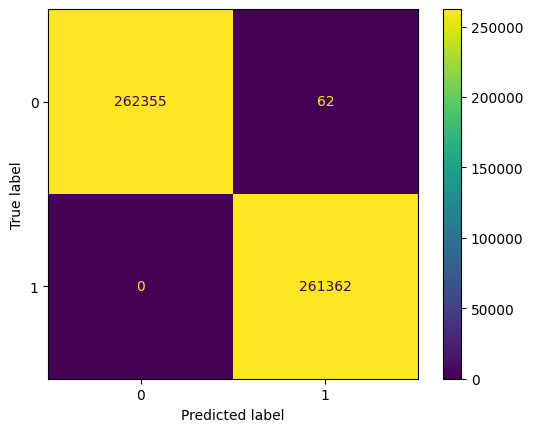

In [26]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=lgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgbest.classes_)
disp.plot()
plt.show()

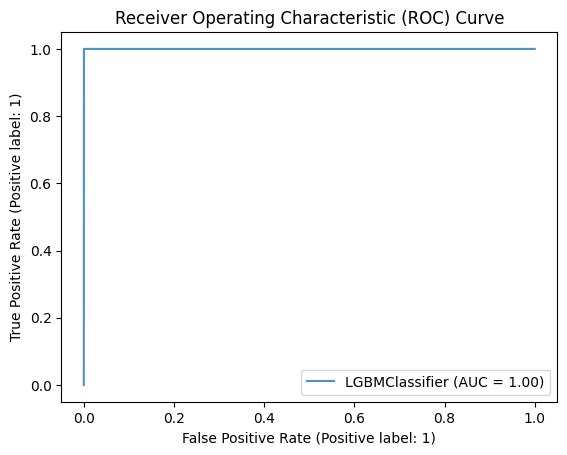

In [27]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(lgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [28]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99976373, 1.        ]), array([1.        , 0.99976373]), array([262417, 261362]))


In [29]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9998818674095047, 0.9998818674095047, None)


In [30]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9998816294658626, 0.9998816294658626, None)


In [31]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9998816294658626, 0.9998821053531469, None)


In [33]:
histgb = HistGradientBoostingClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    histgb.fit(X_train,y_train)
y_pred = histgb.predict(X_test)

In [34]:
accuracy_score(y_test,y_pred)

0.9999007214874975

In [35]:
confusion_matrix(y_test,y_pred)

array([[262374,     43],
       [     9, 261353]])

In [36]:
roc_auc_score(y_test,y_pred)

0.9999008518332976

In [21]:
histgb = HistGradientBoostingClassifier()
param_grid = {
    'max_iter': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1]
}

rand4 = RandomizedSearchCV(histgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [22]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand4.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

In [23]:
rand4.best_params_

{'max_iter': 300, 'max_depth': 20, 'learning_rate': 0.1}

In [25]:
rand4.best_score_

0.9999126538260565

In [20]:
##Training with best parameters
histbest = HistGradientBoostingClassifier(max_iter=300, max_depth=20, learning_rate=0.1)
histbest.fit(X_train,y_train)
y_pred = histbest.predict(X_test)

In [21]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262417
          1       1.00      1.00      1.00      1.00      1.00      1.00    261362

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523779



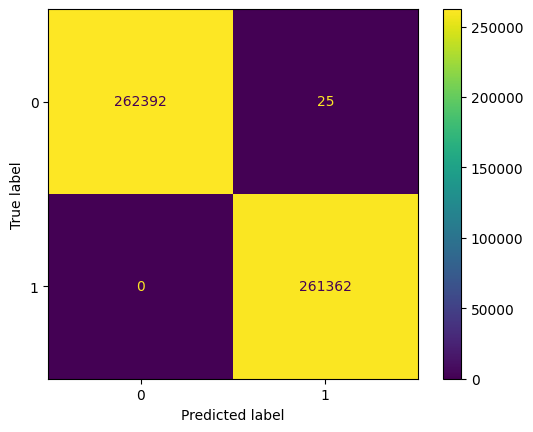

In [22]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=histbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=histbest.classes_)
disp.plot()
plt.show()

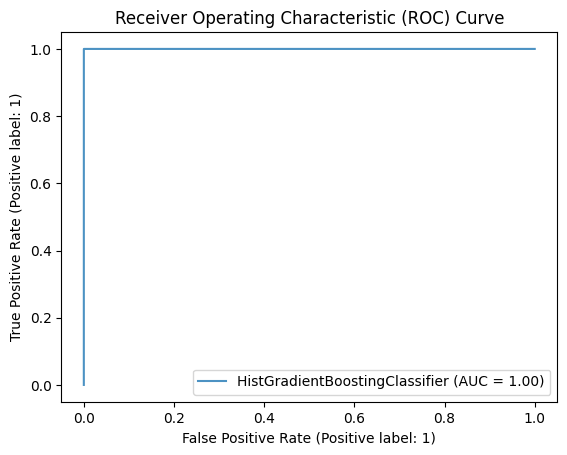

In [23]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(histbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [24]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99990473, 1.        ]), array([1.        , 0.99990473]), array([262417, 261362]))


In [25]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9999523658909293, 0.9999523658909293, None)


In [26]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9999522699459124, 0.9999522699459124, None)


In [28]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9999522699459124, 0.9999524618359463, None)
